# Gaussian Mixture Models and the EM Algorithm
We generate mock 1D and 2D data from sampling from a mixture of gaussians and visualize them.

Then, we fit using our own EM fitting algorithm (varying degrees of complexity on our model). We display a slide show of the EM algorithm in action as the fitted parameters are plotted as we iterate. 

In [28]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import typing
from ipywidgets import Button, VBox, HBox, Output
from IPython.display import display

%matplotlib inline

## Generate Mock Data and Viz

In [3]:
@dataclass
class MockParams:
    mean: np.ndarray
    covariance: np.ndarray
    weight: float

In [4]:
def generate_data(mock_params: typing.List[MockParams], num_samples: int) -> np.ndarray:
    assert len(mock_params) > 0
    means = [p.mean for p in mock_params]
    covs = [p.covariance for p in mock_params]
    weights = np.array([p.weight for p in mock_params])
    assert np.sum(weights) == 1.0
    
    data = np.zeros((num_samples, *(means[0].shape)))
    mixture_indices = np.random.choice(a=range(len(weights)), size=(num_samples,), p=weights)
    for sample_idx in range(num_samples):
        mixture_idx = mixture_indices[sample_idx]

        data[sample_idx] = np.random.multivariate_normal(
            mean=means[mixture_idx],
            cov=covs[mixture_idx],
        )

    return data

In [5]:
params_1d = [
    MockParams(
        mean=np.array([2.0]),
        covariance=np.array([[0.5]]),
        weight=0.3,
    ),
    MockParams(
        mean=np.array([-3.0]),
        covariance=np.array([[0.2]]),
        weight=0.2,
    ),
    MockParams(
        mean=np.array([1.0]),
        covariance=np.array([[0.3]]),
        weight=0.4,
    ),
    MockParams(
        mean=np.array([-1.5]),
        covariance=np.array([[0.6]]),
        weight=0.1,
    ),
]

In [6]:
data_1d = generate_data(params_1d, num_samples=10000)

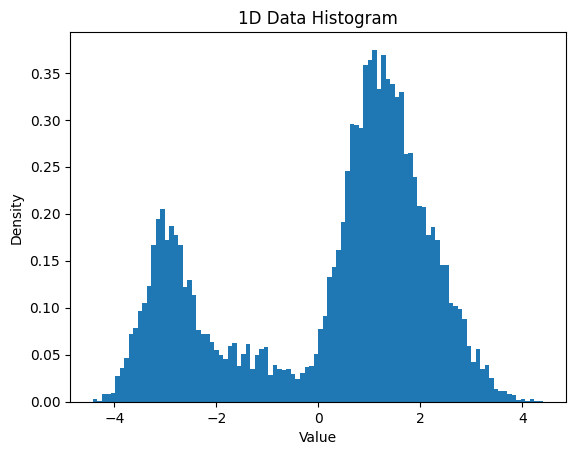

In [7]:
plt.hist(data_1d, bins=100, density=True)
plt.title('1D Data Histogram')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

In [8]:
params_2d = [
    MockParams(
        mean=np.array([2.0, 1.0]),
        covariance=np.array([[0.5, 0.2], [0.2, 0.1]]),
        weight=0.4,
    ),
    MockParams(
        mean=np.array([-3.0, -1.0]),
        covariance=np.array([[0.2, 0.1], [0.1, 0.5]]),
        weight=0.1,
    ),
    MockParams(
        mean=np.array([1.0, 0.0]),
        covariance=np.array([[1.3, 1.1], [1.1, 1.2]]),
        weight=0.3,
    ),
    MockParams(
        mean=np.array([-1.5, 2.0]),
        covariance=np.array([[1.3, 0.5], [0.5, 0.6]]),
        weight=0.2,
    ),
]

In [9]:
data_2d = generate_data(params_2d, num_samples=10000)

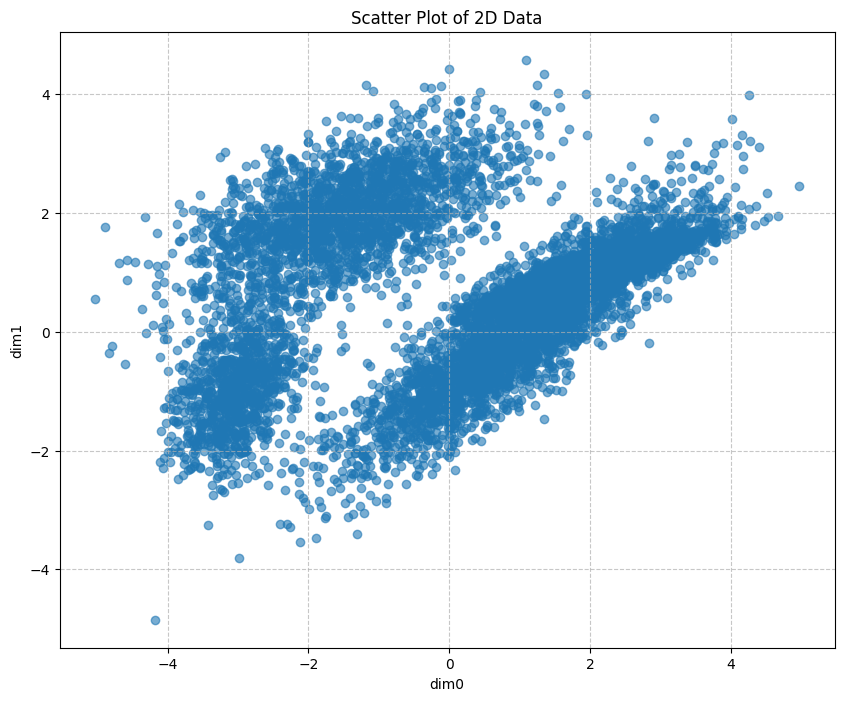

In [10]:
x = data_2d[:, 0]
y = data_2d[:, 1]

plt.figure(figsize=(10, 8))
plt.scatter(x, y, alpha=0.6)

plt.title('Scatter Plot of 2D Data')
plt.xlabel('dim0')
plt.ylabel('dim1')

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

## Apply EM Algorithm with Varying Complexity - Visualize Results

In [13]:
%load_ext autoreload
%autoreload 2
import sys
import os
# Add the parent directory to the sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from algos.gmm import GMMFitter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# initialize the fitters
fitter_1d = GMMFitter(n_clusters=4, n_features=1)
fitter_2d = GMMFitter(n_clusters=4, n_features=2)

In [38]:
# call fit() for 1D data
fitted_models_1d = fitter_1d.fit(data_1d)

In [39]:
fitted_models_1d[-1].get_params()

(array([0.17227977, 0.50837215, 0.31123322, 0.00811486]),
 array([[0.23292059],
        [0.23292059],
        [0.2329206 ],
        [0.23292059]]),
 array([[[15.80270026]],
 
        [[15.80270026]],
 
        [[15.80270013]],
 
        [[15.80270023]]]))

In [31]:
# Initialize the current iteration index
current_iter = 0

# Create an output widget to display the plot
output = Output()

# Flatten data_1d to 1D array
data_1d_flat = data_1d.flatten()

# Precompute static elements
hist_bins = 100
hist_range = (np.min(data_1d_flat), np.max(data_1d_flat))
hist_counts, hist_bins = np.histogram(data_1d_flat, bins=hist_bins, range=hist_range, density=True)

# Generate x values for GMM PDF
x = np.linspace(hist_range[0] - 0.1 * (hist_range[1] - hist_range[0]),
                hist_range[1] + 0.1 * (hist_range[1] - hist_range[0]),
                1000)

def plot_gmm_fit(iter_num):
    with output:
        output.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot histogram using precomputed values
        ax.bar(hist_bins[:-1], hist_counts, width=np.diff(hist_bins), alpha=0.7, color='skyblue', edgecolor='black')
        
        # Plot GMM PDF
        y = [fitted_models_1d[iter_num].pdf(np.array([xi])) for xi in x]
        ax.plot(x, y, 'r-', lw=2, label=f'GMM PDF (Iteration {iter_num})')
        
        ax.set_title(f'Data Histogram and GMM Fit (Iteration {iter_num})')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.show()

def on_left_button_clicked(b):
    global current_iter
    if current_iter > 0:
        current_iter -= 1
    plot_gmm_fit(current_iter)

def on_right_button_clicked(b):
    global current_iter
    if current_iter < len(fitted_models_1d) - 1:
        current_iter += 1
    plot_gmm_fit(current_iter)

# Create buttons for navigation
left_button = Button(description='◀️')
right_button = Button(description='▶️')

# Attach button click events to functions
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Create a VBox to stack the buttons and the output vertically
vbox = VBox([HBox([left_button, right_button]), output])

# Display the VBox
display(vbox)

# Initial plot
plot_gmm_fit(current_iter)

# Display instructions
print("Use the buttons to change iterations.")

Use the buttons to change iterations.


In [32]:
# call fit() for 2D data
fitted_models_2d = fitter_2d.fit(data_2d)

In [34]:
# Initialize the current iteration index
current_iter = 0

# Create an output widget to display the plot
output = Output()

# Extract x and y from data_2d
x = data_2d[:, 0]
y = data_2d[:, 1]

# Create a grid for PDF evaluation
x_range = np.linspace(x.min() - 0.1 * (x.max() - x.min()), x.max() + 0.1 * (x.max() - x.min()), 100)
y_range = np.linspace(y.min() - 0.1 * (y.max() - y.min()), y.max() + 0.1 * (y.max() - y.min()), 100)
X, Y = np.meshgrid(x_range, y_range)

def plot_gmm_fit(iter_num):
    with output:
        output.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Plot scatter
        ax.scatter(x, y, alpha=0.2, color='blue')
        
        # Evaluate PDF on the grid
        XY = np.column_stack([X.ravel(), Y.ravel()])
        Z = np.array([fitted_models_2d[iter_num].pdf(xy) for xy in XY])
        Z = Z.reshape(X.shape)
        
        # Plot PDF as color grid
        im = ax.imshow(Z, extent=[x_range.min(), x_range.max(), y_range.min(), y_range.max()],
                       origin='lower', cmap='YlOrRd', alpha=0.5)
        
        plt.colorbar(im, label='PDF')
        
        ax.set_title(f'2D Data and GMM PDF (Iteration {iter_num})')
        ax.set_xlabel('dim0')
        ax.set_ylabel('dim1')
        ax.grid(True, linestyle='--', alpha=0.7)
        plt.show()

def on_left_button_clicked(b):
    global current_iter
    if current_iter > 0:
        current_iter -= 1
    plot_gmm_fit(current_iter)

def on_right_button_clicked(b):
    global current_iter
    if current_iter < len(fitted_models_2d) - 1:
        current_iter += 1
    plot_gmm_fit(current_iter)

# Create buttons for navigation
left_button = Button(description='◀️ Left')
right_button = Button(description='Right ▶️')

# Attach button click events to functions
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Create a VBox to stack the buttons and the output vertically
vbox = VBox([HBox([left_button, right_button]), output])

# Display the VBox
display(vbox)

# Initial plot
plot_gmm_fit(current_iter)

# Display instructions
print("Use the buttons to change iterations.")

Use the buttons to change iterations.
